## Correlation

##### Calculation of the correlation between solar wind speed and the total electron content of the ionosphere. Investigation of the variation of the correlation values with time and with latitude. Here an annual variation was discovered in previous studies, which will be proved and investigated by examining a long time series.

### DATA SOURCE
##### Total Electron Content of ionosphere
###### https://cdaweb.gsfc.nasa.gov/pub/data/gps/
##### solar radio flux at 10.7 cm (2800 MHz)
###### ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly
###### https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
##### Solar wind speed
###### http://www.srl.caltech.edu/ACE/ASC/level2/lvl2DATA_SWEPAM.html

### ___________________________________________

#### External Libraries

In [29]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import enum

os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
from spacepy import pycdf
from pathlib import Path
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

#### General Functions

In [37]:
# calculates number of days between given dates
# this is used verify there are accurate number of entries in the data set
def numberOfDaysInDates(start, end):
    startDate = datetime.strptime(start, dateFormat)
    endDate = datetime.strptime(end, dateFormat)
    delta = endDate - startDate
    return delta.days + 1


# An empty dataframe is initialised with the given metadata
# attribute name in metadata is used to create the column names
def initDataFrame(metadata):
    columnNames = []
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        columnNames.append(attribute)   
        
    df = pd.DataFrame(columns=columnNames)
    return df


# extract data values from text lines based on the given meta data
# metadata comprises what is the data, type of the data and positions need to be extracted
# Threshold value: if the attribute value goes beyond thresold value then it is considered as NaN
def extractDataFromTxtLine(txt, metadata):
    value = {}
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        startPosition = element[_start_position] if _start_position in element else 0
        endPosition = element[_end_position] if _end_position in element else 0
        thresholdValue = element[_threshold_value] if _threshold_value in element else 0
        dataDateFormat = element[_date_format] if _date_format in element else None
        try:
            attrValue = txt[startPosition:endPosition]
            if attrValue == '':
                break
            if thresholdValue != 0:
                try:
                    attrValue = float(attrValue)
                    attrValue = float('NaN') if attrValue <= 0 else attrValue
                    # checks attribute value goes above threshold value. if goes beyod invalidate
                    if attrValue > thresholdValue:
                        attrValue = float('NaN')
                except:
                    attrValue = float('NaN')
                    error = 'Value cannot be converted to float'
                    log(error)
            value[attribute] = attrValue
        except:
            error = 'No data available at this position'
            log(error)
    return value


# make date formats in data to yyyy-mm-dd
# remove redundant datas
# add values to time series from start date to end date if any entries are missing
def cleanAndFormatData(data, metadata):
    dataDateFormat = None
    for element in metadata:
        dataDateFormat = element[_date_format] if _date_format in element else None
    # set date format to yyyy-mm-dd
    data[_date] = pd.to_datetime(data[_date], format=dataDateFormat)
    
    # extract data only inbetween start date and end date(analysis time period)
    data = data[(data[_date] >= startDate) & (data[_date] <= endDate)]
    
    
    # set date as index for the dataframe
    data = data.set_index(_date)
    
    # remove duplicates
    data = data[~data.index.duplicated(keep='first')]
    
    #check final data set has accurate number of entries
    dataLength = data.shape[0]
    if dataLength != numberOfDays:
        error = 'Number of entries mismatch. Check data'
        log(error)
        log('Automatic index correction')
        data = fillTimeSeries(data)
    return data


# fill time series index if any dates are missing
# index is filled by a start date and end date. 
# It will check for any date missing between start and end date.
# Creates series from start and end date then reindex the original data set with the date series.
# fills NaN for missing values
def fillTimeSeries(data):
    strSDate = datetime.strptime(startDate, '%Y-%m-%d')
    strEDate = datetime.strptime(endDate, '%Y-%m-%d')
    timeSeries = pd.DataFrame({ _date: pd.Series([strSDate, strEDate])})
    timeSeries.set_index(_date, inplace=True)
    data = data.append(timeSeries)
    idx = pd.date_range(min(data.index), max(data.index))
    data = data[~data.index.duplicated(keep='first')]
    data = data.reindex(idx, fill_value=float('NaN'))
    return data


# Fills missing values by interpolation. 
def fillNaNValueWithInterpolation(data, column):
    data[column] = data[column].interpolate()
    data[column].head(4)
    
    return data


# calculate moving average with a window
# window size is 27 and minimum period is 17
def calculateMovingAvg(data, valueColumn, movingAvgColumn):
    data[movingAvgColumn] = data[valueColumn].rolling(window=windowSize, min_periods=windowSize-10).mean()
    return data


# calculate relative difference of original value and moving average value
def calculateRelativeDifference(data, valueColumn, movingAvgColumn, relDiffColumn):
    data[relDiffColumn] = ((data[valueColumn] - data[movingAvgColumn])/data[movingAvgColumn])*100
    return data

def getStartAndEndDateOfYear(year):
    first_day_of_year = str(year) + '-01-01'
    last_day_of_year = str(year) + '-12-31'
    
    return (first_day_of_year, last_day_of_year)


def extractDataByDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values('date') >= startDate) & 
                   (data.index.get_level_values('date') <= endDate)]
    return extData

sDate = '1998-01-01'
eDate = '2020-12-31'


def extractDataByDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values('date') >= startDate) & 
                   (data.index.get_level_values('date') <= endDate)]
    return extData



def extractDataByIndexDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values(level=0) >= startDate) & 
                   (data.index.get_level_values(level=0) <= endDate)]
    return extData


def extractDataAtDate(data, date):
    extData = data[pd.to_datetime(data.index.get_level_values(level=0))==date]
    return extData

#### Read Data & Write Data File

In [5]:
# Read hdf files. 
# file name should contain complete path to the file
def readH5File(fileName):
    df = pd.DataFrame()
    try:
        df = pd.read_hdf(fileName)
        return df
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    return df
        
# Read txt files. 
# file name should contain complete path to the file       
def readTextFile(fileName):
    try:
        dataFile = open(fileName, 'r')
        txtData = dataFile.read()
        return txtData
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    
    
# Read cdf (common data format). Refer https://cdf.gsfc.nasa.gov/
# Make sure cdf library is installed and CDF_LIB path is defined
# Link : https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_0/windows/
# os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
# Make sure pycdf libray is installed
def readCDFFile(fileName):
    try:
        cdfFile = pycdf.CDF(fileName)
        return cdfFile
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
        
def saveToHDFFile(dataframe, filePath):
    try:
        dataframe.to_hdf(filePath, key='df')
    except:
        error = 'Failed to save dataframe: ' + filePath 
        log(error)

#### Constants

In [20]:
startYear = 1997
endYear = 2020
startDate = str(startYear) + '-01-01'
endDate = str(endYear) + '-12-31'
analysisPeriod = np.arange(startYear, endYear+1)
dateFormat = '%Y-%m-%d'
numberOfDays = numberOfDaysInDates(startDate, endDate)

f10_7_max_value = 300
sws_max_value = 900

windowSize = 27
minPeriod = 20

_attribute = 'attribute'
_start_position = 'start_position'
_end_position = 'end_position'
_date = 'date'
_threshold_value = 'threshold_value'
_date_format = 'date_format'

# ------------------f10.7 variables
_f10_7 = 'f10_7'
_f10_7_ma_27 = 'f10_7_ma_27'
_f10_7_rel_diff = 'f10_7_diff_rel'

# ------------------solar wind speed variables
_sws = 'sws'
_sws_ma_27 = 'sws_ma_27'
_sws_rel_diff = 'sws_diff_rel'

#-------------------total electron content variables


final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/Final Plot/'

mv_period = 3
mv_period_2 = 3

#### Configurations

In [7]:
F10_7_FOLDER = "C:/Users/davi_fr/Documents/Project/data/F10.7cm radiofluxindex/"

# dataPosition variable contain how to extarct data from string based on position and length
# format: [[attribure, start_position, end_position, threshold_value, date_format],...]
# threshold value: 
f10_7DataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 10},
                {_attribute: _f10_7, 
                 _start_position: 149, 
                 _end_position: 156, 
                 _threshold_value: f10_7_max_value, 
                 _date_format: None}]




f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/f10_7/f10_7.h5'
sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/sws/sws.h5'

# final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/Final Plot/'
final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/result_plots_2/'

#### Log

In [8]:
def writeToLogFile(log):
    dt = datetime.now()
    log = str(dt) + '\t' + log + '\n' 
    file_name = 'log_file.txt'
    f = open(file_name, 'a+')  # open file in append mode
    f.write(log)
    f.close()

def log(message):
    writeToLogFile(message)
#     print(message)

#### Read and format F10.7 radio flux files

In [ ]:


f10_7_data = initDataFrame(f10_7DataPosition)
filePath =  'C:/Users/davi_fr/Documents/Thesis Project Final/data/Kp_ap_Ap_SN_F107_since_1932.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(filePath)
for dataLine in data.splitlines():
    if dataLine[:1] != '#':
        values = extractDataFromTxtLine(dataLine, f10_7DataPosition)
        try:
            f10_7_data = f10_7_data.append(values, ignore_index=True)
        except:
            error = 'empty data set'
            log(error)

f10_7_data = cleanAndFormatData(f10_7_data, f10_7DataPosition)
f10_7_data = fillNaNValueWithInterpolation(f10_7_data, _f10_7)
f10_7_data = calculateMovingAvg(f10_7_data, _f10_7, _f10_7_ma_27)
f10_7_data = calculateRelativeDifference(f10_7_data, _f10_7, _f10_7_ma_27, _f10_7_rel_diff)
print(f10_7_data)
saveToHDFFile(f10_7_data, f10_7_file_path)
        


#### Read and format Solar wind speed files

In [ ]:
# dataPosition variable contain how toextarct data from string based on position and length
# format: [[attribure, start_position, lenght],...]
swsDataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 8},
                {_attribute: _sws, _start_position: 8,  
                 _end_position: 18, 
                 _threshold_value: sws_max_value, 
                 _date_format: '%Y  %j'}]

sws_data = initDataFrame(swsDataPosition)
swsfilePath =  'C:/Users/davi_fr/Documents/Project_1/data/ACE SWEPAM Level 2 Data/ACE_SWEPAM_Data 01022022.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(swsfilePath)
data = data.partition("BEGIN DATA")[2]
for dataLine in data.splitlines():
    values = extractDataFromTxtLine(dataLine, swsDataPosition)
    try:
        sws_data = sws_data.append(values, ignore_index=True)
    except:
        error = 'empty data set'
        log(error)

sws_data = cleanAndFormatData(sws_data, swsDataPosition)
sws_data = fillNaNValueWithInterpolation(sws_data, _sws)
sws_data = calculateMovingAvg(sws_data, _sws, _sws_ma_27)
sws_data = calculateRelativeDifference(sws_data, _sws, _sws_ma_27, _sws_rel_diff)
print(sws_data)
saveToHDFFile(sws_data, sws_file_path)

#### TEC Constants

In [9]:
_ut = 'ut'
_lat = 'lat'
_lon = 'lon'
_epoch = 'Epoch'
_tecUHR = 'tecUHR'
_tecEHR = 'tecEHR'
_tecCOR = 'tecCOR'
_tecCOD = 'tecCOD'

_tecESA = 'tecESA'
_tecESR = 'tecESR'
_tecIGR = 'tecIGR'
_tecIGS = 'tecIGS'
_tecJPL = 'tecJPL'
_tecJPR = 'tecJPR'
_tecUPC = 'tecUPC'
_tecUPR = 'tecUPR'

_tecUQR = 'tecUQR'


_tec_yearly_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec/'
_tec_mov_avg_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_mov_avg/'
_tec_rel_diff_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/'
_tec_lon_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_lon_mean/'
_tec_ut_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_ut_mean/'


_tec_ut_mean_map_file = 'utMeanTec' + str(startYear) + '_' + str(endYear) + '.h5'


_corr_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_f10_7/corr_tec_x_f10_7.h5'
_corr_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_sws/corr_tec_x_sws.h5'
_corr_norm_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_f10_7/corr_norm_tec_x_f10_7.h5'
_corr_norm_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_sws/corr_norm_tec_x_sws.h5'


_corr_tec_f10_7_upper_c_of_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_upper_cof_interval.h5'
_corr_tec_f10_7_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_lower_cof_interval.h5'
_corr_tec_sws_upper_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_upper_cof_interval.h5'
_corr_tec_sws_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_lower_cof_interval.h5'



_corr_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_f10_7_seasonal.h5'
_corr_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_sws_seasonal.h5'
_corr_norm_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_f10_7_seasonal.h5'
_corr_norm_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_sws_seasonal.h5'



#### Total Electron Content

In [ ]:
# calculate number of period in the start and end date in the given frequncy
# if it is hourly frequncy then number of day in the start and end date is multipled with 24
def getTimeSeriesPeriod(startDate, endDate, frequency):
    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.strptime(endDate, "%Y-%m-%d")
    multiplier = 1
    if frequency == 'H':
        multiplier = 24
    timeSeriesperiod = (abs((endDate - startDate).days) + 1) * multiplier
    return timeSeriesperiod
    
    
# generate a series of date array of given frequency 
# data generated in this way to avoid missing dates in the downlaoded data set
# frequency 'H' defines hourly, 'D' defines daily
def generateTimeSeries(strStartDate, strEndDate, frequency):
    period = getTimeSeriesPeriod(strStartDate, strEndDate, frequency)
    timeSeries = pd.date_range(strStartDate, periods=period, freq=frequency)
    return timeSeries

# generate latitude array values in between +90 to -90 having a step of -2.5
def generateLatitudeArray():
    return np.arange(87.5, -90, -2.5)
# generate longitude array values in between +180 to -180 having a step of -5   
def generateLongitudeArray():
    return np.arange(-180, 185, 5)

# generate an empty dataframe with index as date and hourly ut and columns as latitude and longitude
# empty dataframe replica of original data.
# prepare columns and index values
def generateInitialData(date):
    date = date.strftime('%Y-%m-%d')
    lat = generateLatitudeArray()
    lon = generateLongitudeArray()
    timeArray = generateTimeSeries(date, date, 'H')
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    timeIndex = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    locationIndex = pd.MultiIndex.from_product([lat, lon], 
                                               names=[_lat, _lon])
    return initTecDataFrame(timeIndex, locationIndex)

# return a dataframe with given index and columns
# values will be NaN
def initTecDataFrame(index, columns):
    df = pd.DataFrame(np.nan, index=index, columns=columns)
    return df

# extract tec data from cdf files
# input as raw data and satellites as priority wise
def extractTecData(data, tecVariables):
    latArray = data['lat'][:]
    lonArray = data['lon'][:]
    timeArray = data['Epoch'][:]
    timeArraySize = len(timeArray)
    locationSize = len(latArray) * len(lonArray)
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    
    locations = [latArray, lonArray]
    locationIndex = pd.MultiIndex.from_product(locations, 
                                               names=[_lat, _lon])
    
        
    tecValueArray = []

    for variables in tecVariables:
        if len(tecValueArray) == 0:
            tecValueArray = data[variables][:]
        else:
            altTecValueArray = data[variables][:]
            tecValueArray = np.where( tecValueArray <= 0, altTecValueArray, tecValueArray)
            
    tecValueArray = np.reshape(tecValueArray, (timeArraySize, locationSize))
    tecDataFrame = pd.DataFrame(tecValueArray)
    tecDataFrame.columns = locationIndex
    tecDataFrame.index = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    tecDataFrame[tecDataFrame <= 0] = np.nan
    return tecDataFrame

# generated file path string for 3 temporal resolutions; 1 hour, 15 mins and 2 hrs
# date should be in %Y%m%d format
def getTecFilePath(date):
    fileDate = date.strftime('%Y%m%d')
    folderYear = str(date.year) + '/'
    DATA_ROOT_PATH = "C:/Users/davi_fr/Documents/Project_1/data/"
    HR_1_DATA_FOLDER = "tec_1hr/"
    HR_2_DATA_FOLDER = "tec2hr_igs/"
    MIN_15_DATA_FOLDER = "tec15min_igs/"


    HR_1_FILENAME = 'gps_tec1hr_igs_'
    HR_2_FILENAME = 'gps_tec2hr_igs_'
    MIN_15_FILENAME = 'gps_tec15min_igs_'

    DATA_FILE_ENDING = '_v01.cdf'

    file1Hr = DATA_ROOT_PATH + HR_1_DATA_FOLDER + folderYear + HR_1_FILENAME + fileDate + DATA_FILE_ENDING
    file2Hr = DATA_ROOT_PATH + HR_2_DATA_FOLDER + folderYear + HR_2_FILENAME + fileDate + DATA_FILE_ENDING
    file15Min = DATA_ROOT_PATH + MIN_15_DATA_FOLDER + folderYear + MIN_15_FILENAME + fileDate + DATA_FILE_ENDING
    
    tec_1hr_var = [_tecUHR, _tecEHR, _tecCOR, _tecCOD]
    tec_15Min_var = [_tecUQR]
    tec_2hr_var = [_tecCOD, _tecCOR, _tecESA, _tecESR, _tecIGR, _tecIGS, _tecJPL, _tecJPR, _tecUPC, _tecUPR]
    
    
    tecFileConfig = [{'file_path': file1Hr, 'tec_stations': tec_1hr_var},
                     {'file_path': file15Min, 'tec_stations': tec_15Min_var},
                     {'file_path': file2Hr, 'tec_stations': tec_2hr_var}]
    
    return tecFileConfig


folderPathRoot = "C:/Users/davi_fr/Documents/Project_1/data/tec_1hr/"



        
        

#### Extract TEC data

In [ ]:
analysisDateSeries = generateTimeSeries(startDate, endDate, 'D')
tecData = pd.DataFrame()
for date in analysisDateSeries:
    tecFileConfigs = getTecFilePath(date)
    tecDataDaily = generateInitialData(date)
    for tecFileConfig in tecFileConfigs:
        filePath = tecFileConfig['file_path']
        tecStations = tecFileConfig['tec_stations']
        if Path(filePath).is_file():
            data = readCDFFile(filePath)
            data = extractTecData(data, tecStations)
            tecDataDaily = tecDataDaily.where(tecDataDaily.notnull(),data)
        else:
            error = 'No file found: ' + date.strftime(dateFormat)
            log(error)
#     if len(tecDataDaily) != 0:
#         print(tecDataDaily)
    
    tecData = pd.concat([tecData, tecDataDaily])
    if date.is_year_end:
#         print(tecData)
        tecYear = date.year
        tecFilePath = _tec_yearly_file_path + str(tecYear) + '.h5'
        saveToHDFFile(tecData, tecFilePath)
        status = str(tecYear) + ' File Saved'
        log(status)
        tecData = pd.DataFrame()

#### TEC 27 day moving average  and relative difference for each UT

In [ ]:
def readTECFile(year):
    tecYear = [year-1, year, year+1]
    tecData = pd.DataFrame()
    for year in tecYear:
        tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
        tecFile = readH5File(tecFilePath)
        tecData = pd.concat([tecData, tecFile])
    return tecData

def tecMovingAverage(tecData):
    moving_avg_27 = tecData.groupby([_ut]).rolling(window=windowSize, min_periods=minPeriod).mean().reset_index(level=0, drop=True)
    return moving_avg_27

def sliceDataYearly(dataFrame, year):
    data = pd.DataFrame()
    try:
        data = dataFrame[pd.to_datetime(dataFrame.index.get_level_values(_date)).year == year]
        print(data)
    except:
        error = 'failed to slice data between: ' + startDate + ' and ' + endDate
        log(error)
   
    return data

def saveMovingAvg(tecData, year):
    tecFilePath = _tec_mov_avg_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Moving Average File Saved'
    log(status)
    return True

def saveRelativeDifference(tecData, year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Relative difference File Saved'
    log(status)
    return True
    
for year in analysisPeriod:
    tecData = readTECFile(year)
#     (startDate, endDate) = getStartAndEndDateOfYear(year)
    moving_avg = tecMovingAverage(tecData)
    diffRel = ((tecData - moving_avg)/moving_avg)*100
    moving_avg = sliceDataYearly(moving_avg, year)
    diffRel = sliceDataYearly(diffRel, year)
    saveMovingAvg(moving_avg, year)
    saveRelativeDifference(diffRel, year)
#     print(diffRel)
    
#     print(diffRel.loc[startDate:endDate, :])


#### Plot function for season maps

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def findBounds(a, b):
    boundValue = a if a > b else b
    if a < 0:
        a = a * -1
    if b < 0:
        b = b* -1
    boundValue = a if a > b else b
    bounds = np.linspace(-boundValue,boundValue,10)
    print(boundValue)
    return bounds

def getCorrelationBounds(df):
    maxValue = df.max().max()
    minValue = df.min().min()
#     print(maxValue, minValue)
    maxValue = maxValue + 0.1
    minValue = minValue - 0.1
    maxValue = round(maxValue, 1)
    minValue = round(minValue, 1)
    # print(maxValue, minValue)
    bounds = findBounds(minValue, maxValue)
    # bounds = np.linspace(minValue,maxValue,10)
    # bounds = np.linspace(-1,+1,20)
    
    return bounds

def plotSeasonalMap(df, title):
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]

    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    plt.figure(figsize=(9, 4))
    plt.pcolormesh(df, cmap='seismic')
    cbar = plt.colorbar()
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    bounds = getCorrelationBounds(df)
    plt.clim(bounds.min(),bounds.max())
    plt.clim(-0.7,0.7)
    plt.xlabel('Month')
    plt.ylabel('Latitude')
    cbar.set_label('Correlation Coefficient')
#     plt.title(title, pad=20)    
    
    return True


def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

#### Reducing relative differece of TEC to longitude and UT average

In [ ]:
def readRelDiffTECFile(year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    tecData = pd.DataFrame()
    tecData = readH5File(tecFilePath)
    return tecData

def meanLongitude(tec):
    tecLonReduced = tec.groupby(level = _lat, axis = 1).mean()
    return tecLonReduced

def meanUT(tec):
    tecUTReduced = tec.groupby(level = _date).mean()
    return tecUTReduced

def saveLongitudeMeanTec(tecData, year):
    tecFilePath = _tec_lon_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Longitude mean File Saved'
    log(status)
    return True

def saveUtMeanTec(tecData, year):
    tecFilePath = _tec_ut_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' UT mean File Saved'
    log(status)
    return True

def saveUtMeanTecSingleFile(tecData):
    tecFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
    saveToHDFFile(tecData, tecFilePath)
    status = tecFilePath + ' UT mean in single File Saved'
    log(status)
    return True


meanUTTecFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)
    

#### TEC Map daily average; latitude x longitude

In [ ]:
meanUTTecMapFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)

#### Correlation Computation

In [ ]:
def crossCorrelation(parameter_1, parameter_2):
#     print(parameter_1)
#     print(parameter_2)
    df = parameter_1.rolling(90).corr(parameter_2)
    return df

def adjustData(data, threshold=-9999):
    data = data.fillna(0)
    if threshold > 0:
        data = data.where(data < 100, other=0)
    return data


def gaussianWindowNormalisation(parameter_1, parameter_2):
    wsize = windowSize * 3
    
    norm = parameter_1.copy()
    norm[:] = np.NaN
    
    for shift in np.arange(wsize / 2, len(parameter_1)-wsize/2+1):
        gseries = np.exp(- 0.5 * (((np.arange(1,len(parameter_1)+1)) - shift) / wsize * 4) ** 2)

        param_1_norm = parameter_1.multiply(gseries, axis=0, fill_value=0)
        param_2_norm = parameter_2.multiply(gseries, axis=0, fill_value=0)

        corrNorm = param_1_norm.corrwith(param_2_norm.shift(0))
        i_shift = int(shift) + 45
        if i_shift < len(norm):
            norm.iloc[i_shift] = corrNorm
        
    return norm

tecUtMeanFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
f10_7_file_path = f10_7_file_path
sws_file_path =  sws_file_path

tecData = readH5File(tecUtMeanFilePath)
tecData = adjustData(tecData, 100)

f10_7Data = readH5File(f10_7_file_path)
f10_7Data = f10_7Data[_f10_7_rel_diff]
f10_7Data = adjustData(f10_7Data)

swsData = readH5File(sws_file_path)
swsData = swsData[_sws_rel_diff]
swsData = adjustData(swsData)

corrTecF10_7 = crossCorrelation(tecData, f10_7Data)
corrTecSws = crossCorrelation(tecData, swsData)

normF10_7 = gaussianWindowNormalisation(tecData, f10_7Data)
print(normF10_7)


normSws = gaussianWindowNormalisation(tecData, swsData)
print(normSws)


_corr_tec_x_f10_7_file_path
_corr_tec_x_sws_file_path
_corr_norm_tec_x_f10_7_file_path
_corr_norm_tec_x_sws_file_path


saveToHDFFile(corrTecF10_7, _corr_tec_x_f10_7_file_path)
status = tecFilePath + ' correlation tec x f10.7 File Saved'
log(status)

saveToHDFFile(corrTecSws, _corr_tec_x_sws_file_path)
status = tecFilePath + ' correlation tec x sws File Saved'
log(status)
    
saveToHDFFile(normF10_7, _corr_norm_tec_x_f10_7_file_path)
status = tecFilePath + ' normalised correlation tec x f10.7 File Saved'
log(status)
    

saveToHDFFile(normSws, _corr_norm_tec_x_sws_file_path)
status = tecFilePath + ' normalised correlation tec x sws File Saved'
log(status)
# print(corrTecF10_7[60])
# print(corrTecSws)


#### correlation confidence interval

In [ ]:

def confidenceInterval(data):
    XCorr = data
    z = np.arctanh(XCorr)
    sig2 = 1 /90
    upperConfInterval = np.tanh(z + 1.96 * np.sqrt(sig2))
    lowerConfInterval = np.tanh(z - 1.96 * np.sqrt(sig2))
    
    return (lowerConfInterval, upperConfInterval)
    
    
corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_f10_7)


saveToHDFFile(lowerConfInterval, _corr_tec_f10_7_lower_cof_interval)
status = _corr_tec_f10_7_lower_cof_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)

saveToHDFFile(upperConfInterval, _corr_tec_f10_7_upper_c_of_interval)
status = _corr_tec_f10_7_upper_c_of_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)



corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_sws)

saveToHDFFile(upperConfInterval, _corr_tec_sws_upper_cof_interval)
status = _corr_tec_sws_upper_cof_interval + ' upper confidence interval - correlation tec x sws File Saved'
log(status)

saveToHDFFile(lowerConfInterval, _corr_tec_sws_lower_cof_interval)
status = _corr_tec_sws_lower_cof_interval + ' lower confidence interval - correlation tec x sws File Saved'
log(status)


#### Seasonal Mean

In [ ]:

def computeSeasonalMean(data):
    mean = data.groupby([pd.to_datetime(data.index.get_level_values(_date)).month, 
                         pd.to_datetime(data.index.get_level_values(_date)).day]).mean()
    mean.index.names = ['month', 'day']
    return mean

corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
norm_corr_tec_sws = readH5File(_corr_norm_tec_x_sws_file_path)

seasonalCorrTecF10_7 = computeSeasonalMean(corr_tec_f10_7)
seasonalCorrTecSws = computeSeasonalMean(corr_tec_sws)
seasonalNormCorrTecF10_7 = computeSeasonalMean(norm_corr_tec_f10_7)
seasonalNormCorrTecSws = computeSeasonalMean(norm_corr_tec_sws)


saveToHDFFile(seasonalCorrTecF10_7, _corr_tec_f10_7_seasonal)
status = _corr_tec_f10_7_seasonal + ' correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalCorrTecSws, _corr_tec_sws_seasonal)
status = _corr_tec_sws_seasonal + ' correlation tec x sws seasonal mean File Saved'
log(status)


saveToHDFFile(seasonalNormCorrTecF10_7, _corr_norm_tec_f10_7_seasonal)
status = _corr_norm_tec_f10_7_seasonal + ' normalised correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalNormCorrTecSws, _corr_norm_tec_sws_seasonal)
status = _corr_norm_tec_sws_seasonal + ' normalised correlation tec x sws seasonal mean File Saved'
log(status)

print('finished')

#### Plot TEC

C:\Users\davi_fr\AppData\Local\Temp/ipykernel_22748/1620141992.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  tecData = tecData.mean(level=0)


date
1997-01-01   NaN
1997-01-02   NaN
1997-01-03   NaN
1997-01-04   NaN
1997-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Name: 60.0, Length: 8766, dtype: float64
date
1997-01-01   NaN
1997-01-02   NaN
1997-01-03   NaN
1997-01-04   NaN
1997-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Name: 30.0, Length: 8766, dtype: float64
date
1997-01-01   NaN
1997-01-02   NaN
1997-01-03   NaN
1997-01-04   NaN
1997-01-05   NaN
              ..
2020-12-27   NaN
2020-12-28   NaN
2020-12-29   NaN
2020-12-30   NaN
2020-12-31   NaN
Name: 0.0, Length: 8766, dtype: float64


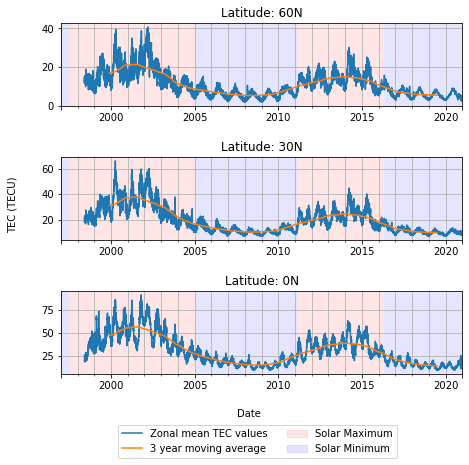

In [13]:
tec_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og"
tec_data_og = pd.DataFrame()
for year in analysisPeriod:
    tec_file_path = tec_file + "\\" + str(year) + ".h5"
    tecData = readH5File(tec_file_path)
    tecData = tecData[[60, 30, 0]]
    tecData = tecData.mean(level=0)
    tec_data_og = tec_data_og.append(tecData)
    

windowSize = 3*365

tec_data_og = tec_data_og.groupby(level = 'lat', axis = 1).mean()
tec_data_og_mean = tec_data_og.rolling(windowSize).mean().shift(int(windowSize/2)*-1)


tec_data_og.index = pd.to_datetime(tec_data_og.index)
tec_data_og_mean.index = pd.to_datetime(tec_data_og_mean.index)





lat = [60, 30 ,0]


fig, axs = plt.subplots(len(lat))
fig.set_figheight(6)
fig.set_figwidth(8)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    
    
    data_lat = tec_data_og[(plotlat)]
    data_lat.plot(ax=axs[j])
    data_mean_lat = tec_data_og_mean[(plotlat)]
#     print(data_mean_lat)
    data_mean_lat.plot(ax=axs[j])
    
    
    axs[j].grid('on', which='minor', axis='x' )
    axs[j].grid('off', which='major', axis='x' )
    axs[j].grid('on', which='minor', axis='y' )
    axs[j].grid('off', which='major', axis='y' )



    axs[j].set_title('Latitude: {}N'.format(plotlat))
    axs[j].set_xlabel("")
    
    axs[j].axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
    axs[j].axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
    axs[j].axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
    axs[j].axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
    axs[j].axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)

fig.subplots_adjust(right=0.8)

fig.text(0.43, 0.01, 'Date', ha='center')
fig.text(0.01, 0.5, 'TEC (TECU)', va='center', rotation='vertical')

red_line = Line2D([0], [0], color='tab:blue', label='Zonal mean TEC values')
orange_line = Line2D([0], [0], color='tab:orange', label='3 year moving average')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, orange_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.55))


plt.savefig(final_plot_location +'tec_lat_0_30_60.pdf',dpi=300, bbox_inches = 'tight')


#### Plot F10.7 Solar Flux

f10_7    66.6
Name: 2018-11-27 00:00:00, dtype: float64


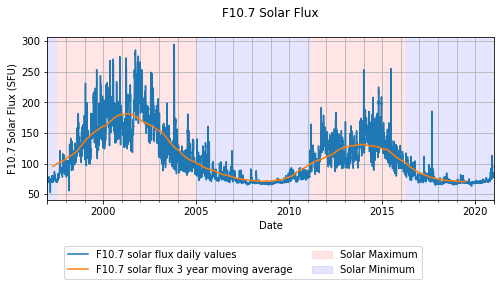

In [14]:
f10_7_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
f10_7Data = readH5File(f10_7_file)
print(f10_7Data.iloc[8000])
windowSize = 3*365
f10_7Data['moving_avg'] = f10_7Data.rolling(window=windowSize, min_periods=int(windowSize*60/100)).mean()
f10_7Data['moving_avg'] = f10_7Data['moving_avg'].shift(int(windowSize/2)*-1)
ax = f10_7Data.plot(figsize=(8, 3), legend=None)
ax.set_xlabel("Date")
ax.set_ylabel("F10.7 Solar Flux (SFU)")
ax.grid('on', which='minor', axis='x' )
ax.grid('off', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('off', which='major', axis='y' )


ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)


plt.title('F10.7 Solar Flux', pad=20)

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='tab:blue', label='F10.7 solar flux daily values')
green_line = Line2D([0], [0], color='tab:orange', label='F10.7 solar flux 3 year moving average')
# gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))



plt.savefig(final_plot_location + 'f10_7_smm.pdf', dpi=300, bbox_inches = "tight")
plt.show()

#### Plot Solar Wind Speed

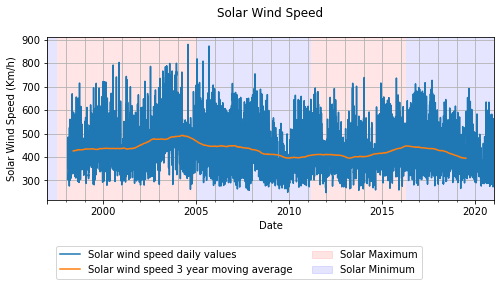

In [15]:
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
sws_file_ma = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
swsData = readH5File(sws_file)
swsData['moving_avg'] = swsData.rolling(window=3*365, min_periods=int(windowSize*60/100)).mean()
swsData['moving_avg'] = swsData['moving_avg'].shift(int(windowSize/2)*-1)

# swsData['moving_avg_cubic_interpolation'] = swsData['moving_avg'].interpolate(method='cubic')


ax = swsData.plot(figsize=(8, 3), legend=None)
ax.set_xlabel("Date")
ax.set_ylabel("Solar Wind Speed (Km/h)")
ax.grid('on', which='minor', axis='x' )
ax.grid('off', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('off', which='major', axis='y' )

ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)

plt.title('Solar Wind Speed', pad=20)

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='tab:blue', label='Solar wind speed daily values')
green_line = Line2D([0], [0], color='tab:orange', label='Solar wind speed 3 year moving average')
# gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))


plt.savefig(final_plot_location + 'sws_smm.pdf', dpi=300, bbox_inches = "tight")


plt.show()

#### Plot TEC IGS Map

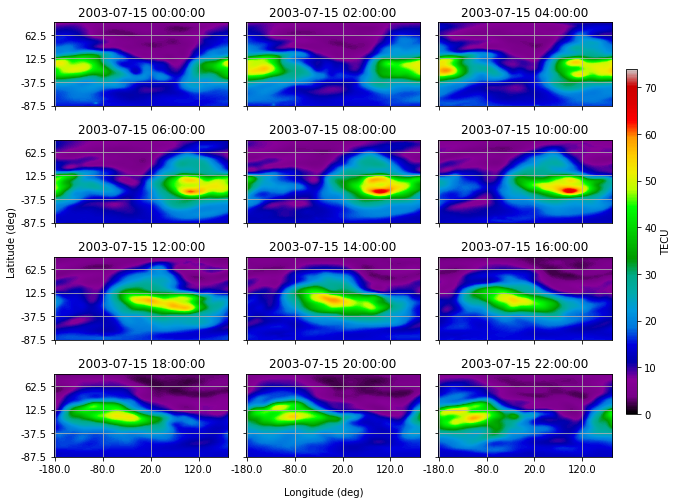

In [9]:
file20000715 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\load_data\\tec_2hr\\gps_tec2hr_igs_20030715_v01.h5"
date = '2003-07-15'
time = ['00:00:00', '02:00:00', '04:00:00', '06:00:00', '08:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00', '18:00:00', '20:00:00', '22:00:00']
time = np.array_split(time,4)

df = readH5File(file20000715)
# print(df.max().max())
maxValue = df.max().max()

# print(df)
xindex = np.unique(df.index.get_level_values('lon'))
yindex = np.unique(df.index.get_level_values('lat'))
ytiks = range(0,71,20)
# yidx = np.linspace(0, len(yindex) - 1, 4).astype(int)
# print(yidx)


ylbl = yindex[ytiks]
xtiks = range(0,74,20)
xlbl = xindex[xtiks]

fig, axs = plt.subplots(len(time), len(time[0]),sharex=True, sharey=True, gridspec_kw={'hspace': 0.4, 'wspace': 0.1})
fig.set_figheight(8)
fig.set_figwidth(10)

for i in np.arange(len(time)):
    t = time[i]
    for j in np.arange(len(t)):
        tt = t[j]
        data = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '{} {}'.format(date, tt)]['tecIGS']
        data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
        data = data.sort_index(axis=1, ascending=True)
        
        img = axs[i, j].imshow(data, interpolation='gaussian', aspect='auto', cmap='nipy_spectral', vmin=0, vmax=maxValue)
        axs[i, j].set_title('{} {}'.format(date, tt))
        axs[i, j].invert_yaxis()
        
        axs[i, j].set_yticks(ytiks) 
        axs[i, j].set_yticklabels(ylbl)
        
        axs[i, j].set_xticks(xtiks) 
        axs[i, j].set_xticklabels(xlbl)
        axs[i, j].grid()
#         axs[i, j].set_ylim(ymin=0, ymax=23)

cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cbar = fig.colorbar(img, cax=cbar_ax, label='TECU')


fig.text(0.5, 0.06, 'Longitude (deg)', ha='center')
fig.text(0.06, 0.5, 'Latitude (deg)', va='center', rotation='vertical')


# df = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '2003-07-15 12:00:00']['tecIGS']
# df = df.unstack()
# df = df.sort_index(axis=0, ascending=False)
# df = df.sort_index(axis=1, ascending=True)
# # print(df)
# fig = plt.figure(figsize=(12, 7), dpi=200)
# graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
# cb = plt.colorbar(graph, shrink = 0.5)
fig.savefig(final_plot_location + 'igs_tec_map' + '.jpg', bbox_inches='tight', dpi= 200)
plt.show()

#### Plot Window Size selection

lat              12.5
lon                 0
date                 
1997-01-01        NaN
1997-01-02        NaN
1997-01-03        NaN
1997-01-04        NaN
1997-01-05        NaN
...               ...
2020-12-27  14.300000
2020-12-28  17.341667
2020-12-29  16.579167
2020-12-30  18.433334
2020-12-31  15.383333

[8766 rows x 1 columns]


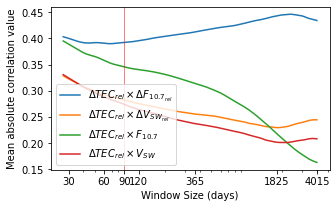

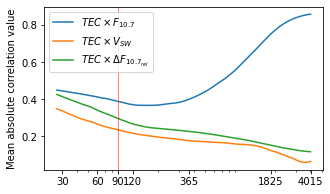

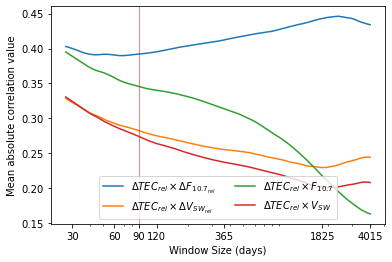

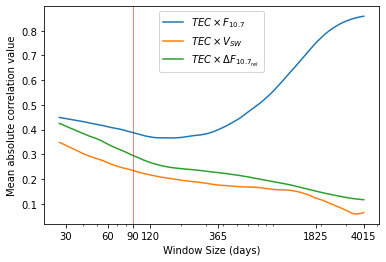

In [30]:
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\tec\\"

f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
tec = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\"

tecRelDiffData = pd.DataFrame()
tecData = pd.DataFrame()
loc = (12.5,0)
for year in analysisPeriod:
    tec_rel_diff_path = tec_rel_diff + '{}.h5'.format(year)
    temptecRelDiffData = readH5File(tec_rel_diff_path)[[loc]].interpolate()
    tecRelDiffData = tecRelDiffData.append(temptecRelDiffData)


    tec_path = tec + '{}.h5'.format(year)
    temptecData = readH5File(tec_path)[[loc]].interpolate()
    tecData = tecData.append(temptecData)



tecRelDiffData = tecRelDiffData.groupby(level = ['date'], axis = 0).mean()
tecData = tecData.groupby(level = ['date'], axis = 0).mean()
print(tecData)







F10Data = readH5File(f10).interpolate()
F10RelDiffData = readH5File(f10_7_rel_diff).interpolate()
swsData = readH5File(sws).interpolate()
swsRelDiffData = readH5File(sws_rel_diff).interpolate()












meanCorrelation = pd.DataFrame(columns=['window_size', 'relTEC_relSWS', 'relTEC_relF10', 'relTEC_SWS', 'relTEC_F10', 'tec_f10', 'tec_relF10', 'tec_sws'])

for windowSize in np.arange(27, 4015):

#     print(windowSize)

    correlation_relTEC_relSWS = tecRelDiffData.rolling(windowSize).corr(swsRelDiffData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_relTEC_relF10 = tecRelDiffData.rolling(windowSize).corr(F10RelDiffData['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    correlation_relTEC_SWS = tecRelDiffData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_relTEC_F10 = tecRelDiffData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    correlation_tec_sws = tecData.rolling(windowSize).corr(swsData['sws']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_tec_f10 = tecData.rolling(windowSize).corr(F10Data['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]
    correlation_tec_relF10 = tecData.rolling(windowSize).corr(F10RelDiffData['f10_7']).shift(int(windowSize/2)*-1).abs().mean().values[0]

    row = {'window_size': windowSize, 
               'relTEC_relSWS': correlation_relTEC_relSWS, 
               'relTEC_relF10': correlation_relTEC_relF10,
               'relTEC_SWS': correlation_relTEC_SWS,
               'relTEC_F10': correlation_relTEC_F10,
               'tec_f10': correlation_tec_f10, 
               'tec_relF10': correlation_tec_relF10,
               'tec_sws': correlation_tec_sws
          }
#     print(row)
    meanCorrelation = meanCorrelation.append(row, ignore_index=True) 

meanCorrelation = meanCorrelation.set_index('window_size')

# print(meanCorrelation)










from IPython.display import display, Latex




fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])


for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
ax.plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
ax.plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
ax.plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
ax.set_xlabel('Window Size (days)')
ax.legend()
fig.savefig('mean_abs_corr_rel_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
plt.show()



fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())


ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
ax.plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
ax.plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
ax.legend()


fig.savefig('mean_abs_corr_pure_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
plt.show()





# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(12, 4)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[0].set_xticks([30, 60, 90, 120, 365, 1825, 4015])
# # ax[0].set_ylim([0.05, 0.35])

# ax[1].set_xticks([30, 60, 90, 120, 365, 1825, 4015])

# for axis in [ax[0].xaxis, ax[0].yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# for axis in [ax[1].xaxis, ax[1].yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# ax[0].plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
# ax[0].plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
# ax[0].plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
# ax[0].plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
# ax[0].axvline(90, color='red', linewidth=0.5)
# ax[0].set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
# ax[0].set_xlabel('Window Size (days)')
# ax[1].set_xlabel('Window Size (days)')
# ax[0].set_ylabel('Mean absolute correlation value')
# ax[1].set_ylabel('Mean absolute correlation value')
# ax[1].plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
# ax[1].plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
# ax[1].plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
# ax[1].axvline(90, color='red', linewidth=0.5)
# ax[1].set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
# ax[0].legend()
# ax[1].legend()
# fig.savefig('mean_abs_corr_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150)
# plt.show()


from IPython.display import display, Latex




fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])


for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['relTEC_relF10'], label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
ax.plot(meanCorrelation['relTEC_relSWS'], label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
ax.plot(meanCorrelation['relTEC_F10'], label=r'$\Delta TEC_{rel} \times F_{10.7}$')
ax.plot(meanCorrelation['relTEC_SWS'], label=r'$\Delta TEC_{rel} \times V_{SW}$')
ax.axvline(90, color='red', linewidth=0.5)
# ax.set_title(r'Mean absolute correlation of $\Delta TEC_{rel}$ at '+ str(loc[0])+'N '+str(loc[1])+'E')
ax.set_xlabel('Window Size (days)')
ax.legend(loc = "lower center", ncol=2)
fig.savefig('mean_abs_corr_rel_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150, bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax.set_xscale('log')
ax.set_xticks([30, 60, 90, 120, 365, 1825, 4015])
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())


ax.set_ylabel('Mean absolute correlation value')
ax.plot(meanCorrelation['tec_f10'], label=r'$ TEC \times F_{10.7}$')
ax.plot(meanCorrelation['tec_sws'], label=r'$ TEC \times V_{SW}$')
ax.plot(meanCorrelation['tec_relF10'], label=r'$ TEC \times \Delta F_{10.7_{rel}}$')
ax.axvline(90, color='red', linewidth=0.5)
ax.set_xlabel('Window Size (days)')
# ax.set_title('Mean absolute correlation of TEC at {}N {}E'.format(loc[0], loc[1]))
ax.legend()


fig.savefig('mean_abs_corr_pure_tec_{}N_{}E.pdf'.format(loc[0], loc[1]), dpi=150, bbox_inches='tight')
plt.show()

#### Correlation between relative difference TEC and F10.7 solar flux

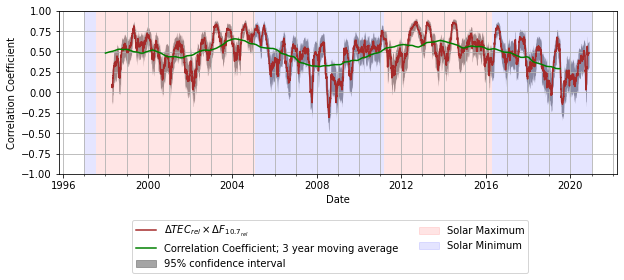

In [22]:
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
# tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\normalised_correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
# tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)


tec_f10_7_corrr = extractDataByDate(tec_f10_7_corrr, sDate, eDate)
# tec_f10_7_norm_corrr = extractDataByDate(tec_f10_7_norm_corrr, sDate, eDate)
tec_f10_7_corrr_lowerLimit = extractDataByDate(tec_f10_7_corrr_lowerLimit, sDate, eDate)
tec_f10_7_corrr_upperLimit = extractDataByDate(tec_f10_7_corrr_upperLimit, sDate, eDate)

lat = 12.5
tec_f10_7_corrr = tec_f10_7_corrr[[lat]]
# tec_f10_7_norm_corrr = tec_f10_7_norm_corrr[lat]
tec_f10_7_corrr_lowerLimit = tec_f10_7_corrr_lowerLimit[lat]
tec_f10_7_corrr_upperLimit = tec_f10_7_corrr_upperLimit[lat]

movingAvgCorr = tec_f10_7_corrr.rolling(window=int(365*mv_period), min_periods=5).mean().shift(int((365*mv_period)/2)*-1)
movingAvgf10_7Data = f10_7Data.rolling(window=int(365*mv_period_2), min_periods=5).mean()

f10_7Data = extractDataByDate(f10_7Data, sDate, eDate)


fig, ax = plt.subplots()
fig.set_size_inches(10, 3)


ax.plot(tec_f10_7_corrr, label='Correlation F10.7 Solar Flux X TEC (Box Window)', color="brown", alpha=1)
ax.plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)


ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(-1,1)

ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit
yAxisUpper = tec_f10_7_corrr_upperLimit
ax.fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.8, linewidth=0, color='gray', label='95% confidence interval')


ax.set_xlabel('Date')
ax.set_ylabel('Correlation Coefficient')

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='brown', label=r'$\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
green_line = Line2D([0], [0], color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, gray_patch, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))

# axs[1].legend(handles=[line_1, line_2, line_fill, red_patch, blue_patch])


# plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N.png', dpi=300)
plt.savefig(final_plot_location + 'corr_tec_f10_7_{}{}.pdf'.format(lat, 'N' if lat >= 0 else 'S'), dpi=150, bbox_inches = "tight")
plt.show()

#### Correlation between relative difference TEC and Solar Wind speed

High:  0.787398363700749
Low:  -0.6129563307221415
D


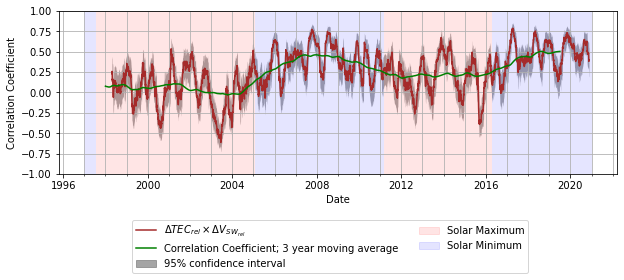

In [23]:
meanCorrelation = readH5File('mean_correlation_latitude_all_window_size.h5')
meanCorrelationsws = meanCorrelation[(52.5,'correlation_sws_rel_diff')]
meanCorrealtionsws = meanCorrelationsws.loc[90]
# print(meanCorrelation[(52.5,'correlation_sws_rel_diff')])
# print(meanCorrealtionsws)


tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_sws\\tec_sws.h5"
# tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\normalised_correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
# tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)



tec_sws_corrr = extractDataByDate(tec_sws_corrr, sDate, eDate)
# tec_sws_norm_corrr = extractDataByDate(tec_sws_norm_corrr, sDate, eDate)
tec_sws_corrr_lowerLimit = extractDataByDate(tec_sws_corrr_lowerLimit, sDate, eDate)
tec_sws_corrr_upperLimit = extractDataByDate(tec_sws_corrr_upperLimit, sDate, eDate)


lat = 12.5
tec_sws_corrr = tec_sws_corrr[lat]
peakValue = tec_sws_corrr.max()
print('High: ', peakValue)
print('Low: ', tec_sws_corrr.min())

frequency = pd.infer_freq(tec_sws_corrr.index)
print(frequency)

# tec_sws_norm_corrr = tec_sws_norm_corrr[lat]
tec_sws_corrr_lowerLimit = tec_sws_corrr_lowerLimit[lat]
tec_sws_corrr_upperLimit = tec_sws_corrr_upperLimit[lat]
mv_period = 3
movingAvgCorr = tec_sws_corrr.rolling(window=int(365*mv_period), min_periods=5).mean().shift(int((365*mv_period)/2)*-1)
movingAvgf10_7Data = f10_7Data.rolling(window=int(365*mv_period_2), min_periods=5).mean()


fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
ax.plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)', color="brown")

ax.plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)

ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(-1,1)
ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)
# axs[1].axvspan('1998-01-01', '2004-12-31', facecolor='red', alpha=0.2)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit
yAxisUpper = tec_sws_corrr_upperLimit
ax.fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.7, linewidth=0, color='gray', label='95% confidence interval')

ax.set_xlabel('Date')
ax.set_ylabel('Correlation Coefficient')


ax.legend(framealpha=0.4)

red_line = Line2D([0], [0], color='brown', label=r'$\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
green_line = Line2D([0], [0], color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, gray_patch, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))

# axs[1].add_artist(lg)
# plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N.png', dpi=300)
plt.savefig(final_plot_location + 'corr_tec_sws_' + str(lat) + '.pdf', dpi=150, bbox_inches = "tight")
plt.show()


# Getting only the axes specified by ax[0,0]
# extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

#### Latitudinal dependency : Correlation between relative difference TEC and F10.7 solar flux

mean 0.3484652739694808


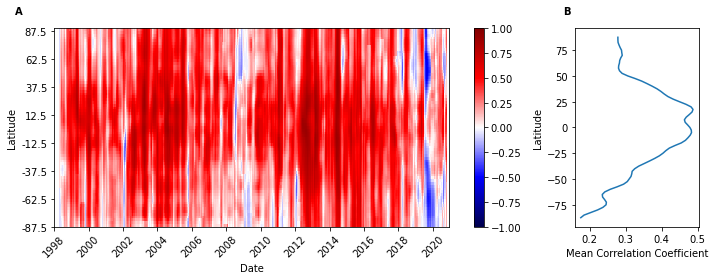

In [33]:
# tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"


tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
# print(tec_f10_7_corrr.max().max())
# print(tec_f10_7_corrr.min().min())
# tec_f10_7_corrr.min()[30:60].plot()
# plt.show()
# tec_f10_7_corrr.max()[-25:40].plot()
# plt.show()

tec_f10_7_corrr = extractDataByDate(tec_f10_7_corrr, sDate, eDate)

corr_mov_avg_date = pd.DataFrame()
for y in range(1998, 2021, 1):
    sy = y
    ey = y+4
    dateData = pd.DataFrame(tec_f10_7_corrr['{}-01-01'.format(sy):'{}-12-31'.format(ey)])
    latData = dateData.T.mean(axis=1).rename('{}'.format(sy))
#     print(latData)
    corr_mov_avg_date = corr_mov_avg_date.append(latData)
    
# corr_mov_avg_date.loc['2017':].T.plot()    
    
tec_f10_7_corrr = tec_f10_7_corrr.T

print('mean', tec_f10_7_corrr.mean().mean())


indexValues = tec_f10_7_corrr.index.values
tiks = range(0,71,10)
lbl = indexValues[tiks]

dateColumn = pd.to_datetime(tec_f10_7_corrr.columns, format='%Y-%m-%d').year
xtiks = range(0,len(dateColumn),732)
xlbl = dateColumn[xtiks]



mean = tec_f10_7_corrr.mean(axis=1)
# (axs2) = mean.plot()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True, gridspec_kw={'width_ratios': [4, 1]})
img = ax1.pcolormesh(tec_f10_7_corrr, cmap='seismic', vmin=-1, vmax=1)
# cbar_ax = fig.add_axes([1, 0.155, 0.015, 0.8])
fig.colorbar(img, ax=ax1)

ax1.set_yticks(tiks) 
ax1.set_yticklabels(lbl)

ax1.set_xticks(xtiks) 
ax1.set_xticklabels(xlbl, rotation=45)
ax1.set_xlabel('Date')
ax1.set_ylabel('Latitude')

ax2.plot(mean.values, mean.index)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Mean Correlation Coefficient')

ax1.text(-0.1, 1.07, 'A', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2.text(-0.1, 1.07, 'B', transform=ax2.transAxes, 
            size=10, weight='bold')
# ax2.set_yticks(tiks) 
# ax2.set_yticklabels(lbl)
fig.savefig(final_plot_location + 'correlation_map_f10_tec_mean' + '.pdf', bbox_inches='tight', dpi= 150)
plt.show()

#### Latitudinal dependency : Correlation between relative difference TEC and Solar Wind speed

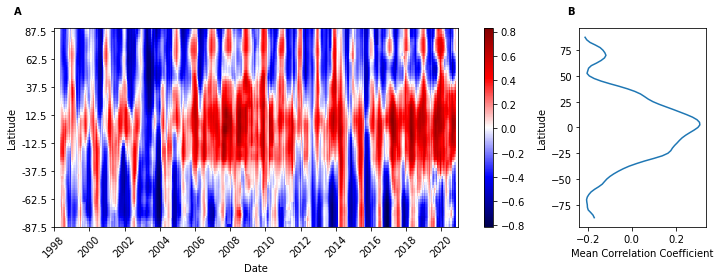

In [35]:
# tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_sws\\tec_sws.h5"


tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_corrr = extractDataByDate(tec_sws_corrr, sDate, eDate)

tec_sws_corrr = tec_sws_corrr.T

indexValues = tec_sws_corrr.index.values
tiks = range(0,71,10)
lbl = indexValues[tiks]
# tec_f10_7_corrr.T.plot()

# plt.clim(-1,1)
dateColumn = pd.to_datetime(tec_sws_corrr.columns, format='%Y-%m-%d').year
xtiks = range(0,len(dateColumn),732)
xlbl = dateColumn[xtiks]

mean = tec_sws_corrr.mean(axis=1)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True, gridspec_kw={'width_ratios': [4, 1]})
img = ax1.pcolormesh(tec_sws_corrr, cmap='seismic')
# cbar_ax = fig.add_axes([1, 0.155, 0.015, 0.8])
fig.colorbar(img, ax=ax1)

ax1.set_yticks(tiks) 
ax1.set_yticklabels(lbl)

ax1.set_xticks(xtiks) 
ax1.set_xticklabels(xlbl, rotation=45)
ax1.set_xlabel('Date')
ax1.set_ylabel('Latitude')

ax2.plot(mean.values, mean.index)
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Mean Correlation Coefficient')
# ax2.set_yticks(tiks) 
# ax2.set_yticklabels(lbl)

ax1.text(-0.1, 1.07, 'A', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2.text(-0.1, 1.07, 'B', transform=ax2.transAxes, 
            size=10, weight='bold')
fig.savefig(final_plot_location + 'correlation_map_sws_tec_mean' + '.pdf', bbox_inches='tight', dpi= 150)
plt.show()

#### Seasonal dependency : Correlation between relative difference TEC and F10.7 solar flux

0.5813994467104611 0.11109852153014076
0.7


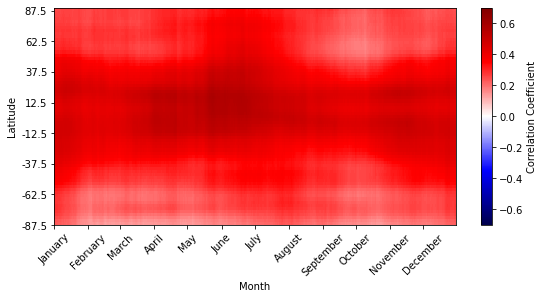

In [26]:
# _corr_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_f10_7_seasonal.h5'
_corr_norm_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_f10_7_seasonal.h5'

_corr_tec_f10_7_seasonal = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\mean\\seasonal_mean_corr_tex_x_f10_7\\seasonal_mean_corr_tex_x_f10_7.h5"

g_corr_f10_day_mean = readH5File(_corr_norm_tec_f10_7_seasonal)

corr_f10_day_mean = readH5File(_corr_tec_f10_7_seasonal)
print(corr_f10_day_mean.max().max(), corr_f10_day_mean.min().min())
corr_f10_day_mean = corr_f10_day_mean.drop((2,29))
g_corr_f10_day_mean = g_corr_f10_day_mean.T
corr_f10_day_mean = corr_f10_day_mean.T

plotSeasonalMap(corr_f10_day_mean, 'Correlation of F10.7 Solar Flux and Total Electron Content\nSeasonal Mean 1998 - 2020')


plt.savefig(final_plot_location + 'corr_tec_f10_7_seasonal_map.pdf', dpi=150, bbox_inches = "tight")
plt.show()

#### Seasonal dependency : Correlation between relative difference TEC and Solar Wind speed

0.371242174809867 -0.4769351685741615
0.6


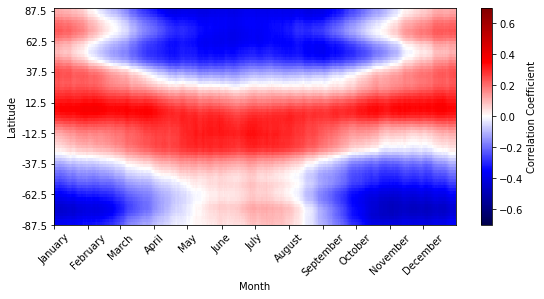

In [27]:
# _corr_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_sws_seasonal.h5'
_corr_tec_sws_seasonal = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\mean\\seasonal_mean_corr_tex_x_sws\\seasonal_mean_corr_tex_x_sws.h5"
_corr_norm_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_sws_seasonal.h5'

g_corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)
corr_sws_day_mean = readH5File(_corr_tec_sws_seasonal)

corr_sws_day_mean = corr_sws_day_mean.drop((2,29))
g_corr_sws_day_mean = g_corr_sws_day_mean.T

# print(corr_sws_day_mean.T.min().sort_values())
print(corr_sws_day_mean.max().max(), corr_sws_day_mean.min().min())

corr_sws_day_mean = corr_sws_day_mean.T

# plotSeasonalMap(g_corr_sws_day_mean, 'Normalised correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))
plotSeasonalMap(corr_sws_day_mean, 'Correlation of Solar Wind Speed and Total Electron Content\nSeasonal Mean 1998 - 2020')

plt.savefig(final_plot_location + 'corr_tec_sws_seasonal_map.pdf', dpi=150, bbox_inches = "tight")
plt.show()

#### Local Time dependency : Correlation between relative difference TEC and F10.7 solar flux

#### Local Time dependency : Correlation between relative difference TEC and Solar Wind speed

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_items_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis0_level2] [items->None]

  f = lambda store: store.put(
C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle

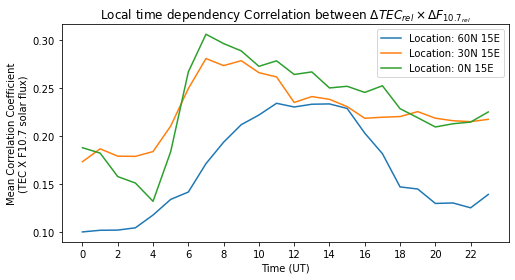

C:\Users\davi_fr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


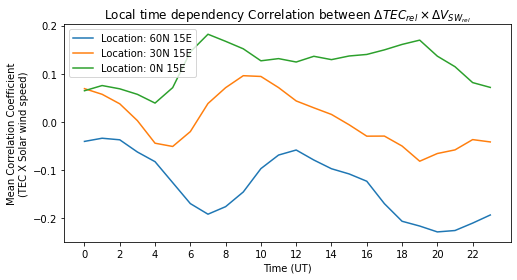

In [40]:
from scipy.signal import savgol_filter
location = [(60, 15), (30, 15), (0, 15)]
# location = [60, 30, 0]
param = ['f10', 'sws']

windowSize = 60
# tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
# sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
# f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"


tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\append\\tec\\tec.h5"
sws_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\sws\\sws.h5"
f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\relative_difference\\f10_7\\f10_7.h5"

f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
f10_7_rel_diff.index = pd.to_datetime(f10_7_rel_diff.index)
# print(f10_7_rel_diff.dtypes)
swsData = readH5File(sws_rel_diff)
swsData.index = pd.to_datetime(swsData.index)
tecDataFull = pd.DataFrame()


for year in analysisPeriod:
#     tecPath = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/computations/relative_difference/tec/' + str(year) + '.h5'
    tecPath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\" + str(year) + '.h5'
    tecData = readH5File(tecPath)[location]
#     tecData = tecData.groupby(level = 'lat', axis =1).mean()
    tecDataFull = tecDataFull.append(tecData)
#     print(tecData)
    
    
tecDataFull = tecDataFull.interpolate()


# tecDataFull = tecDataFull.rolling(2, min_periods = 1).mean().shift(-1)
# print(tecDataFull)
# print(tecDataFull.groupby(level='ut', axis=0).mean())
# tecDataFull.groupby(level='ut', axis=0).mean().plot()
# plt.grid()
# plt.show()

tecDataFull = tecDataFull.unstack()
# tecDataFull.to_csv('time.csv')
# print(tecDataFull)
tecDataFullMa_27 = tecDataFull.rolling(27, min_periods=12).mean().shift(int(27/2)*-1)
tecDataFullRelDiff = ((tecDataFull - tecDataFullMa_27)/tecDataFullMa_27)*100
# print(tecDataFullRelDiff)

# tecDataFullRelDiff[(60, 15)].plot(figsize=(8,3))



# tecDataFull = tecDataFullRelDiff


# tecDataFull = tecDataFull.unstack()
# print(tecDataFull[[tecDataFull.columns[0]]])



figuresize = (8,4)

# tecDataFull = tecDataFull.unstack()
tecDataFull.index = pd.to_datetime(tecDataFull.index)

# tecDataFull[location[0]].mean().plot(figsize=figuresize)
# print(tecDataFull)    

min_period = 27
for par in param:
    if par == 'f10':
        correlation_tec_f10_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(f10_7_rel_diff['f10_7']).shift(int(windowSize/2)*-1)
        correlation_tec_f10_period = extractDataByIndexDate(correlation_tec_f10_period, '1998-01-01', '2020-12-31')
        correlation_tec_f10_period.to_hdf('correlation_tec_f10_loc_60_30_0_15_ut.h5', key='df')
        


    if par == 'sws':
        
        correlation_tec_sws_period = tecDataFull.rolling(windowSize, min_periods = min_period).corr(swsData['sws']).shift(int(windowSize/2)*-1)
        correlation_tec_sws_period = extractDataByIndexDate(correlation_tec_sws_period, '1998-01-01', '2020-12-31')
        correlation_tec_sws_period.to_hdf('correlation_tec_sws_loc_60_30_0_15_ut.h5', key='df')
        

    
            

        
        
sdate = '1998-01-01'
edate = '2020-12-31'
        
feature = 'rel_diff'        
        
        
corr_f10_ut = readH5File('correlation_tec_f10_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()


for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T

    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)


    
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X F10.7 solar flux)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
ax.set_title(r'Local time dependency Correlation between $\Delta TEC_{rel} \times \Delta F_{10.7_{rel}}$')
# ax.set_ylim([-0.6, 0.6])
plt.savefig(final_plot_location + 'mean_correlation_tec_f10_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')

plt.show()









# location = [(60, 15), (30, 15), (0, 15)]
corr_f10_ut = readH5File('correlation_tec_sws_loc_60_30_0_15_ut.h5')[sdate:edate]


meanCorrUt = pd.DataFrame()
for j in np.arange(len(location)):
    loc = location[j]
    dataAtLoc = corr_f10_ut[loc].T

    
    meanCorr =   dataAtLoc.T.mean()
    meanCorrUt = pd.concat((meanCorrUt, meanCorr.rename(loc)), axis=1)
        
fig, ax = plt.subplots()
meanCorrUt.plot(figsize = figuresize, 
                ylabel = 'Mean Correlation Coefficient\n(TEC X Solar wind speed)', 
                xlabel='Time (UT)', 
                ax=ax)
ax.legend(["Location: 60N 15E", "Location: 30N 15E", "Location: 0N 15E"])
ax.set_title(r'Local time dependency Correlation between $\Delta TEC_{rel} \times \Delta V_{SW_{rel}}$')
x = np.arange(0,24, 1)
ax.set_xticks(meanCorrUt.index[::2])
ax.set_xticklabels(x[::2])
# ax.set_ylim([-0.6, 0.6])
# ax.set_ylim([-0.6, 0.6])

plt.savefig(final_plot_location + 'mean_correlation_tec_sws_ut_lat_lon_15E'+feature+'.pdf', bbox_inches = 'tight')
plt.show()